# Evaluating the current spock model with corrected data, and re training the model

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib as plt
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

In [2]:
import sys
sys.path.insert(1, '../summerSPOCK')
from SPOCKalt import *
#Intigration/simsetup.py
from SPOCKalt import simsetup
from SPOCKalt import plotFunctions
# import simsetup
# import plotFunctions

In [3]:
import rebound
import xgboost


In [4]:
#load path and data for resonant datasets
#labels for columns of Initial conditions and labels
col = ['p0m','p0x','p0y','p0z','p0vx','p0vy','p0vz','p1m','p1x','p1y','p1z','p1vx','p1vy','p1vz','p2m','p2x','p2y','p2z','p2vx','p2vy','p2vz','p3m','p3x','p3y','p3z','p3vx','p3vy','p3vz']
lab = ['runstring', 'instability_time',
       'shadow_instability_time', 'Stable']
resPath = 'csvs/resonant/'
resInitial = pd.read_csv(resPath+'initial_conditions.csv',header=None)
resLabels = pd.read_csv(resPath+'labels.csv')
resInitial.columns = col #adds labels to initial condition columns
resset = pd.DataFrame.join(resInitial, resLabels) #joins initial conditions and labels

In [5]:
remLab = pd.read_csv(resPath+'removeLables.csv')

In [6]:
model = xgboost.XGBClassifier()
model.load_model('modelHere.json')


In [7]:
model.get_booster().get_fscore()

{'f0': 6844.0,
 'f1': 5509.0,
 'f2': 6161.0,
 'f3': 6568.0,
 'f4': 5077.0,
 'f5': 5815.0,
 'f6': 5009.0,
 'f7': 6392.0,
 'f8': 4350.0,
 'f9': 4763.0}

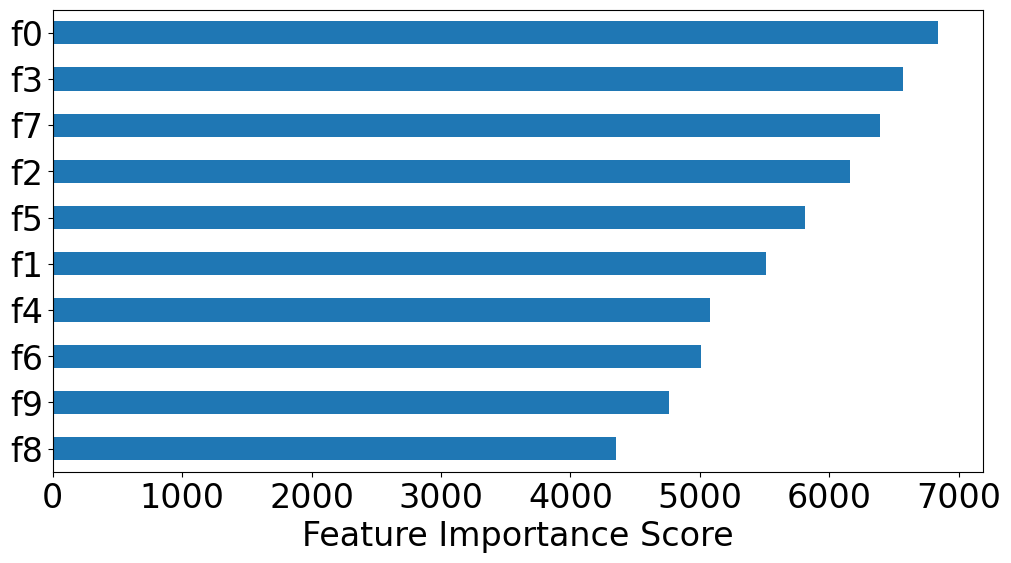

In [8]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
#plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [9]:
datapath = 'training_data/'
csvpath = '../csvs/'
dset = 'resonant/' #just trained on resonant data
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder
csvfolder = csvpath+dset
print(trainingdatafolder)
print(csvfolder)
dataset = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
labels = pd.read_csv(trainingdatafolder+"labels.csv", index_col=0)

training_data/resonant/featuresNorbits10000.0Nout80trio/
../csvs/resonant/


In [10]:
labels = pd.DataFrame.join(labels, remLab['remove'])

In [11]:
labels

,runstring,instability_time,shadow_instability_time,Stable,remove
0,0000000.bin,1.545872e+06,3.063700e+06,False,False
1,0000001.bin,9.990000e+08,9.990000e+08,True,False
2,0000002.bin,9.990000e+08,9.990000e+08,True,False
3,0000003.bin,2.287671e+06,8.392234e+06,False,False
4,0000004.bin,9.668931e+05,3.380350e+05,False,False
...,...,...,...,...,...
113538,9045377.bin,6.990387e+05,8.267916e+05,False,False
113539,9045378.bin,3.075749e+08,6.576003e+08,False,True
113540,9045380.bin,1.193822e+07,3.363291e+07,False,False
113541,9045382.bin,2.064407e+08,4.316851e+07,False,False


In [12]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']
#what is being used to train
features = near + far + megno

Clean the dataset, removing NaNs

In [13]:
%%time
if 'tmax' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 22 µs, sys: 1e+03 ns, total: 23 µs
Wall time: 27.2 µs


In [14]:
mask = (labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)
y = labels[mask][['Stable']]
y2= labels[mask][['Stable','remove']]

X = dataset[mask][features]
tinst = labels[mask]['instability_time']

In [15]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainX2 = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
trainY2 = y2.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testX2 = X.iloc[Nrows:, :]

testY = y.iloc[Nrows:]
testY2 = y2.iloc[Nrows:]
test_tinst = tinst.iloc[Nrows:]

In [16]:
testX2 = testX2.drop(testY2[testY2['remove']==True].index)
testY2 = testY2.drop(testY2[testY2['remove']==True].index)
trainX2 = trainX2.drop(trainY2[trainY2['remove']==True].index)
trainY2 = trainY2.drop(trainY2[trainY2['remove']==True].index)


In [17]:
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix, auc

In [51]:
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,0]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = sklearn.metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

Text(0.5, 1.0, 'ROC curve (AUC = 0.928)')

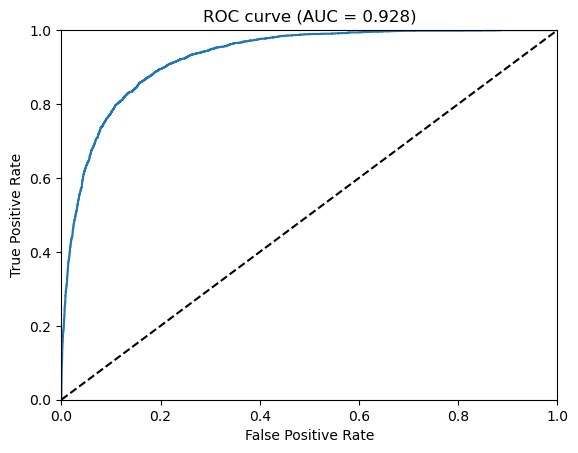

In [52]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.920)')

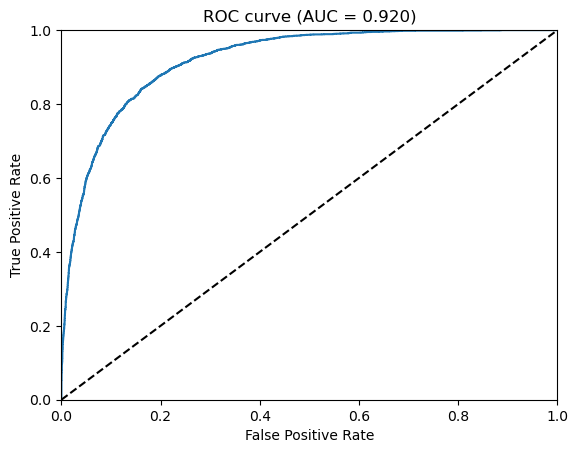

In [53]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX2, testY2['Stable'])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [21]:
import sklearn.metrics
#import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix, auc

# print (sklearn.metrics.roc_auc_score(testY['Stable'],testY['guess']))
# print(accuracy_score(testY['guess'],testY['Stable']))

create a model using original spock paramiters

In [93]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )

In [94]:
model.fit(trainX2, trainY2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [103]:
model.predict_proba(testX2)

array([[0.96924186, 0.00123475],
       [0.967727  , 0.00123475],
       [0.02705619, 0.00123475],
       ...,
       [0.00327448, 0.00123475],
       [0.28638738, 0.00123475],
       [0.01668267, 0.00123475]], dtype=float32)

In [99]:
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,0]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = sklearn.metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

Text(0.5, 1.0, 'ROC curve (AUC = 0.921)')

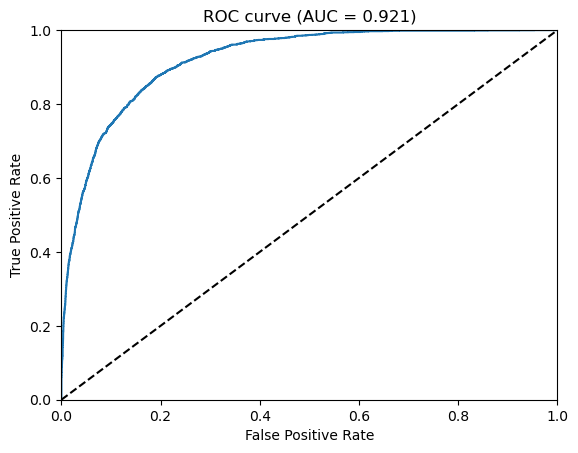

In [100]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX2, testY2['Stable'])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [106]:
trainX.columns

Index(['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'MEGNO',
       'MEGNOstd'],
      dtype='object')